# Tarea 3 Métodos No Lineales
---
## Integrantes: 
- *José Eduardo Caimapo* -  jose.caimapo.12@sansano.usm.cl - 201373573-8
- *Rodrigo Sepúlveda* - rodrigo.sepulveda.12@sansano.usm.cl - 201204766-8

In [231]:
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
from   sklearn.utils           import check_random_state
from   sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support,classification_report
from sklearn.tree import DecisionTreeClassifier as Tree
from sklearn.decomposition import PCA, KernelPCA

## 1. Small Circle inside Large Circle

El objetivo de esta sección es experimentar con algunos modelos no-lineales sobre un problema de juguete generado  para visualizar  algoritmos  de clustering.  Se  trata  de  un  problema  de  clasificación  a  todas  luces linealmente inseparable, en el sentido que, si denotamos por $x \in I\!R^{2}$ un patrón de entrada y por $y \in \{1, -1\}$ su correspondiente etiqueta, no existen $w \in I\!R^2,b \in I\!R$ tal que $y(w^T x + b) \geq p \gt 0$
El problema nos permite 
hacer un recorrido rápido por las grandes ideas en la búsqueda de la ***no-linealidad***.



#### a) Escriba una función que genere n datos etiquetados de la forma $\{(x_1,y_1),...,(x_n,y_n)\}$ con $x_i \in I\!R^{2}, y_i \in \{ 0 , 1\}$, con una distribución de probabilidad que refleje la configuración linealmente inseparable que muestra la Fig 1. Utilice esta función para crear 1000 datos de entrenamiento y 1000 datos de pruebas. Para medir la tendencia de los modelos a ***sobre ajuste***, agregue un $5 \%$ de ruido al dataset, generando x's cercanos a la frontera. Genere un gráfico que muestre datos de entrenamiento y pruebas, identificando cada clase con un color diferente.

In [13]:
def do_circles(n=2000,noisy_n=0.05):
    generator = check_random_state(10)
    linspace = np.linspace(0, 2 * np.pi, n // 2 + 1)[:-1]
    outer_circ_x = np.cos(linspace)
    outer_circ_y = np.sin(linspace)
    inner_circ_x = outer_circ_x * .3
    inner_circ_y = outer_circ_y * .3
    X = np.vstack((np.append(outer_circ_x, inner_circ_x),np.append(outer_circ_y, inner_circ_y))).T
    y = np.hstack([np.zeros(n // 2, dtype=np.intp),np.ones(n // 2, dtype=np.intp)])
    X += generator.normal(scale=noisy_n, size=X.shape)
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.5, random_state=42)
    return X_train,y_train,X_test,y_test

In [14]:
def plot_classifier(clf,X_train,Y_train,X_test,Y_test,model_type):
    f, axis = plt.subplots(1, 1, sharex='col', sharey='row',figsize=(12, 8))
    axis.scatter(X_train[:,0],X_train[:,1],s=30,c=Y_train,zorder=10,cmap='cool')
    axis.scatter(X_test[:,0],X_test[:,1],s=20,c=Y_test,zorder=10,cmap='Greys')
    XX, YY = np.mgrid[-2:2:200j, -2:2:200j]
    if model_type == 'tree':
        Z = clf.predict_proba(np.c_[XX.ravel(), YY.ravel()])[:,0]
    elif model_type == 'ann':
        Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])
    else: raise ValueError('model type not supported')
    Z = Z.reshape(XX.shape)
    Zplot = Z >= 0.5
    axis.pcolormesh(XX, YY, Zplot ,cmap='YlGn')
    axis.contour(XX, YY, Z, alpha=1, colors=["k", "k", "k"], linestyles=["--", "-", "--"],
    levels=[-2, 0, 2])
    plt.show()

In [15]:
X_train,y_train,X_test,y_test = do_circles()

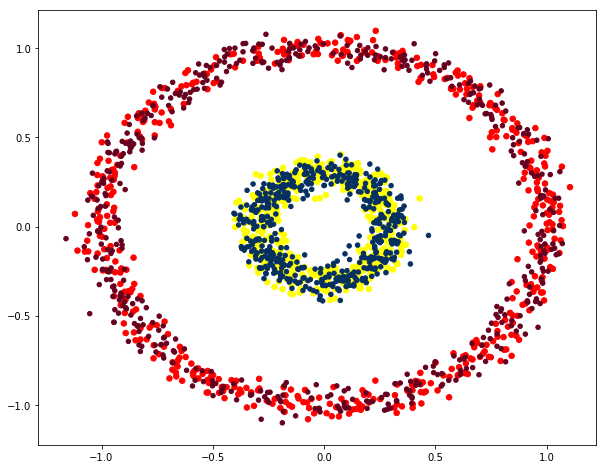

In [129]:
f, axis = plt.subplots(1, 1, sharex='col', sharey='row',figsize=(10,8))
axis.scatter(X_train[:,0],X_train[:,1],s=30,c=y_train,zorder=10,cmap='autumn')
axis.scatter(X_test[:,0],X_test[:,1],s=20,c=y_test,zorder=10,cmap='RdBu')
plt.axis('tight')
plt.legend(fancybox=True, loc=(1,0.8))
plt.show()

#### b) Demuestre  experimentalmente que  una  red  neuronal  artificial  correspondiente  a  1  sola  neurona  (i.e.sin capas escondidas) no puede resolver satisfactoriamente el problema. Puede utilizar la función de activaci ́on y el método deentrenamiento que prefiera. Sea convincente: por ejemplo, intente modificar los parámetros de la máquina de aprendizaje,reportando métricas que permitan evaluar el desempeño del modelo en el problema con cada cambio efectuado.Adapte tambi ́en la funci ́on plot classifier para que  represente  gr ́aficamente  la  soluci ́on  encontrada  por  la  red  neuronal. Describa  y  explique  lo  que observa, reportando gr ́aficos de la soluci ́on s ́olo para algunos casos representativos.

In [72]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
import itertools

#Numero de neuronas
n_h=1
kernel =['uniform','glorot_normal','random_normal']
activation = ['sigmoid','relu','softmax']
loss = ['binary_crossentropy','poisson','squared_hinge']
score_dict={}
i=0
for times in range(5):
    for k,a,l in itertools.product(kernel,activation,loss):
        model = Sequential()
        model.add(Dense(n_h, input_dim=X_train.shape[1], kernel_initializer=k, activation=a))
        model.compile(optimizer=SGD(lr=1), loss=l, metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=50, batch_size=100, verbose=0)
        scores = model.evaluate(X_test, y_test)
        
        name = 'init: {},activation: {},loss: {}'.format(k,a,l)

        #El registro aparece por primera vez, se agrega la key al diccionario

        if (name in score_dict):
            score_dict[name].append(scores[1])
            i=i+1
        #Si existe se agrega el valor a la lista
        else:
            score_dict[name] = [scores[1]]
            i=i+1
    i=0
print('Finalizado.')

1000/1000 [==============================] - 3s 3ms/step
Finalizado.


In [83]:
df = pd.DataFrame(score_dict)
df

,"init: glorot_normal,activation: relu,loss: binary_crossentropy","init: glorot_normal,activation: relu,loss: poisson","init: glorot_normal,activation: relu,loss: squared_hinge","init: glorot_normal,activation: sigmoid,loss: binary_crossentropy","init: glorot_normal,activation: sigmoid,loss: poisson","init: glorot_normal,activation: sigmoid,loss: squared_hinge","init: glorot_normal,activation: softmax,loss: binary_crossentropy","init: glorot_normal,activation: softmax,loss: poisson","init: glorot_normal,activation: softmax,loss: squared_hinge","init: random_normal,activation: relu,loss: binary_crossentropy",...,"init: random_normal,activation: softmax,loss: squared_hinge","init: uniform,activation: relu,loss: binary_crossentropy","init: uniform,activation: relu,loss: poisson","init: uniform,activation: relu,loss: squared_hinge","init: uniform,activation: sigmoid,loss: binary_crossentropy","init: uniform,activation: sigmoid,loss: poisson","init: uniform,activation: sigmoid,loss: squared_hinge","init: uniform,activation: softmax,loss: binary_crossentropy","init: uniform,activation: softmax,loss: poisson","init: uniform,activation: softmax,loss: squared_hinge"
0,0.507,0.305,0.379,0.495,0.588,0.493,0.493,0.493,0.493,0.0,...,0.493,0.0,0.493,0.493,0.566,0.593,0.493,0.493,0.493,0.493
1,0.507,0.361,0.335,0.487,0.641,0.493,0.493,0.493,0.493,0.0,...,0.493,0.0,0.539,0.493,0.658,0.590,0.493,0.493,0.493,0.493
2,0.000,0.304,0.371,0.644,0.609,0.493,0.493,0.493,0.493,0.0,...,0.493,0.0,0.605,0.493,0.579,0.589,0.493,0.493,0.493,0.493
3,0.000,0.347,0.493,0.486,0.591,0.493,0.493,0.493,0.493,0.0,...,0.493,0.0,0.351,0.493,0.650,0.592,0.493,0.493,0.493,0.493
4,0.000,0.596,0.427,0.662,0.561,0.493,0.493,0.493,0.493,0.0,...,0.493,0.0,0.493,0.493,0.505,0.592,0.493,0.493,0.493,0.493


Con los datos de la celda, se observa que con un modelo de una sola neurona se obtienen resultados que los muchos estan bajo el 50% de acuracy, pero además se nota que estos fluctuan si se repite el experimento. Por lo cual se toma para ver las fronteras a ciertos representates que sus valores se mantienen consistentes o sobre el 50%.
$$init: glorot_normal,activation: sigmoid,loss: poisson$$
$$init: glorot_normal,activation: sigmoid,loss: squared_hinge$$
$$init: uniform,activation: sigmoid,loss: binary_crossentropy$$
$$init: uniform,activation: sigmoid,loss: poisson$$

Caso 1


C:\Python36\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


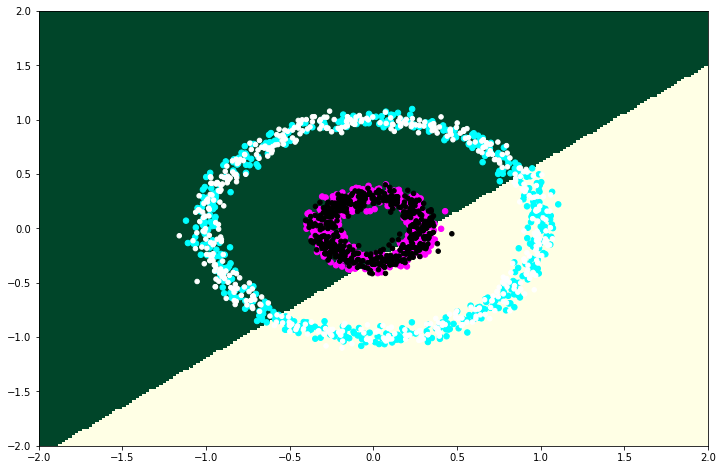

Caso 2


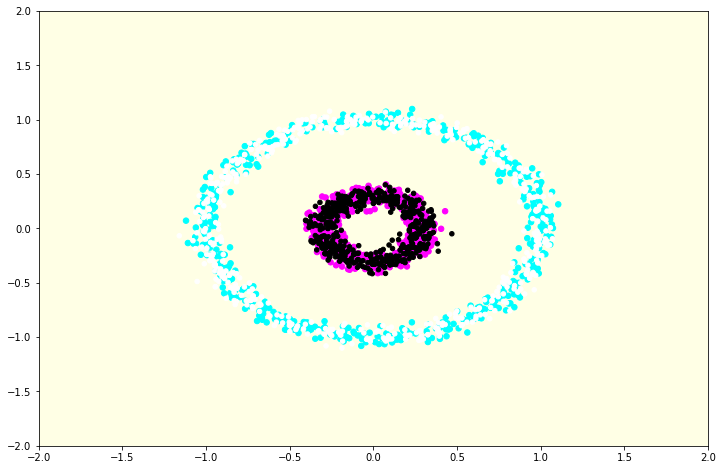

Caso 3


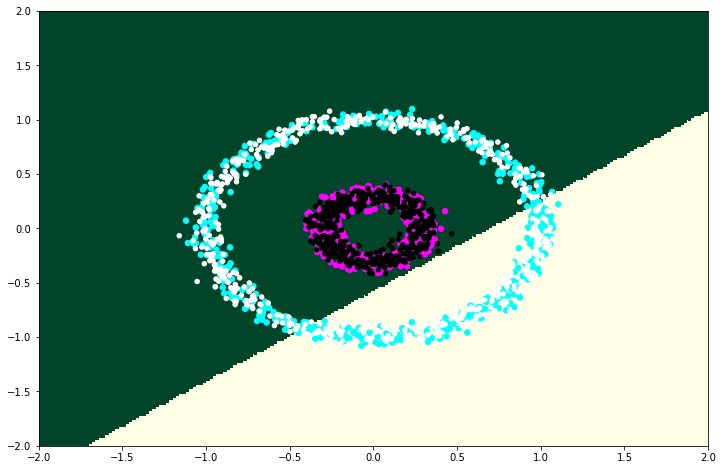

Caso 4


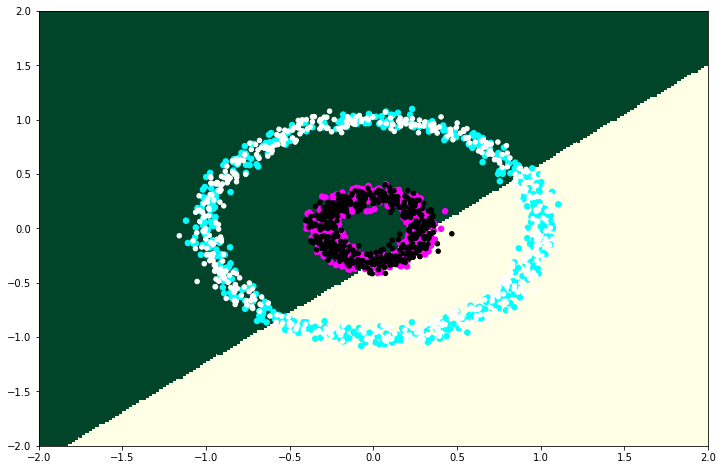

In [87]:
model = Sequential()
model.add(Dense(n_h, input_dim=X_train.shape[1], kernel_initializer='glorot_normal', activation='sigmoid'))
model.compile(optimizer=SGD(lr=1), loss='poisson', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=100, verbose=0)
print('Caso 1')
plot_classifier(model,X_train,y_train,X_test,y_test,'ann')

model = Sequential()
model.add(Dense(n_h, input_dim=X_train.shape[1], kernel_initializer='glorot_normal', activation='sigmoid'))
model.compile(optimizer=SGD(lr=1), loss='squared_hinge', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=100, verbose=0)
print('Caso 2')
plot_classifier(model,X_train,y_train,X_test,y_test,'ann')

model = Sequential()
model.add(Dense(n_h, input_dim=X_train.shape[1], kernel_initializer='uniform', activation='sigmoid'))
model.compile(optimizer=SGD(lr=1), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=100, verbose=0)
print('Caso 3')

plot_classifier(model,X_train,y_train,X_test,y_test,'ann')
model = Sequential()
model.add(Dense(n_h, input_dim=X_train.shape[1], kernel_initializer='uniform', activation='sigmoid'))
model.compile(optimizer=SGD(lr=1), loss='poisson', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=100, verbose=0)
print('Caso 4')
plot_classifier(model,X_train,y_train,X_test,y_test,'ann')

#### c)  Demuestre experimentalmente que una red neuronal artificial con 1 capa escondida puede resolver satisfactoriamente el problema obtenido en (a). Puede utilizar la arquitectura y el método de entrenamiento que prefiera, pero en esta actividad puede optar tranquilamente por usar los hiper-parámetros que se entregan como referencia en el código de ejemplo. Cambie el número de neuronas N h en la red entre 2 y 32 en potencias de 2, graficando el error de entrenamiento y pruebas como  función de N h . Describa y explique lo que observa. Utilice la función plot classifier , diseñada anteriormente, para construir gráficos de la solución en algunos casos representativos

[1, 2, 4, 8, 16, 32]
1000/1000 [==============================] - ETA:  - 0s 128us/step

 Test Accuracy = 1.0, n=4


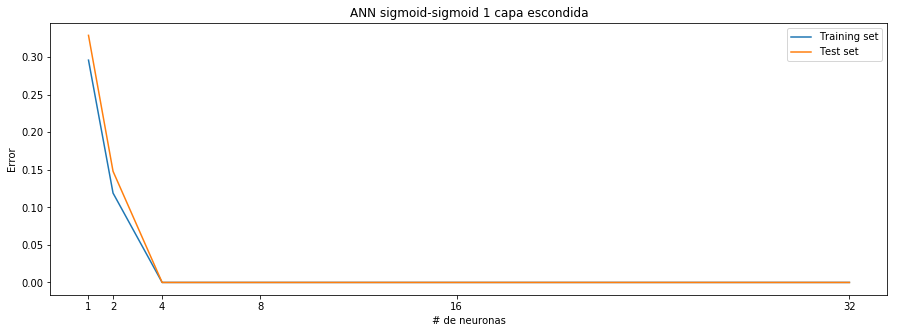

In [149]:
N_h = [pow(2,k) for k in range(6)]
print(N_h)
best_acc = [0,0]
info_train = []
info_test = []
for n in N_h:
    model = Sequential()
    model.add(Dense(n, input_dim=X_train.shape[1], kernel_initializer='uniform', activation='relu'))
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
    model.compile(optimizer=SGD(lr=1), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=50, batch_size=100, verbose=0)
            
    info_train.append(model.evaluate(X_train, y_train)[1])
    
    test_acc = model.evaluate(X_test, y_test)[1]
    info_test.append(test_acc)
    if test_acc > best_acc[0]:
        best_acc = [test_acc,n]
        
print ("\n Test Accuracy = {}, n={}".format(best_acc[0],best_acc[1]))

error_train = [1-i for i in info_train]
error_test = [1-j for j in info_test]


plt.figure( figsize=(15,5))
plt.plot(N_h,error_train, label = "Training set")
plt.plot(N_h,error_test, label = "Test set")
plt.xticks(N_h)
plt.xlabel('# de neuronas')
plt.ylabel('Error')
plt.title('ANN sigmoid-sigmoid 1 capa escondida')
plt.legend(loc = 'upper right')
plt.show()

#### d) Demuestre experimentalmente que stump (árbol de clasificación de 1 nivel) no puede resolver satisfactoriamente el problema anterior. Puede utilizar el criterio y la función de partición que prefiera. Sea convincente:  por  ejemplo,  intente  modificar  los  parámetros  de  la  máquina,  reportando  métricas  que permitan evaluar el desempeño del modelo en el problema con cada cambio efectuado. Adapte también la función plot classifier para que represente gráficamente la solución encontrada por el árbol. Describa y explique lo que observa, reportando gráficos de la solución sólo para algunos casos representativos.

In [162]:
dict_info = {}

C:\Python36\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


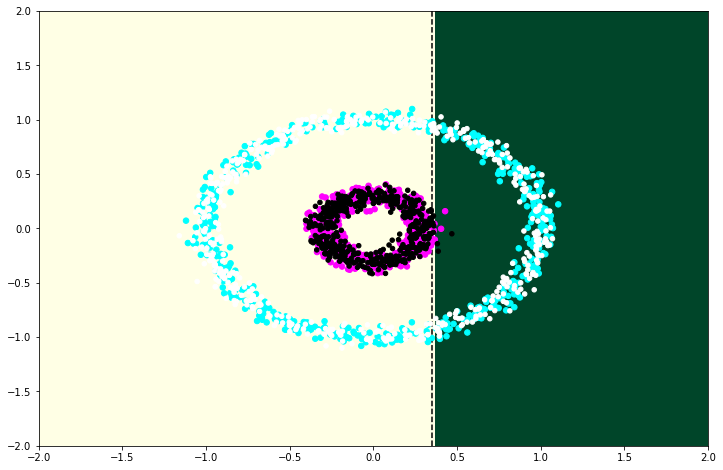

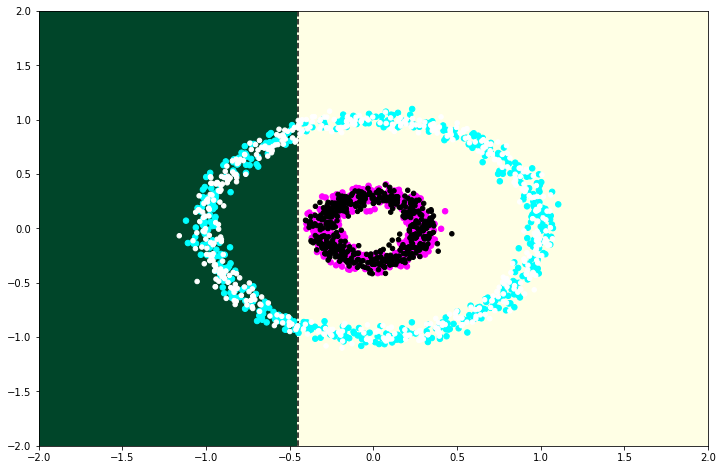

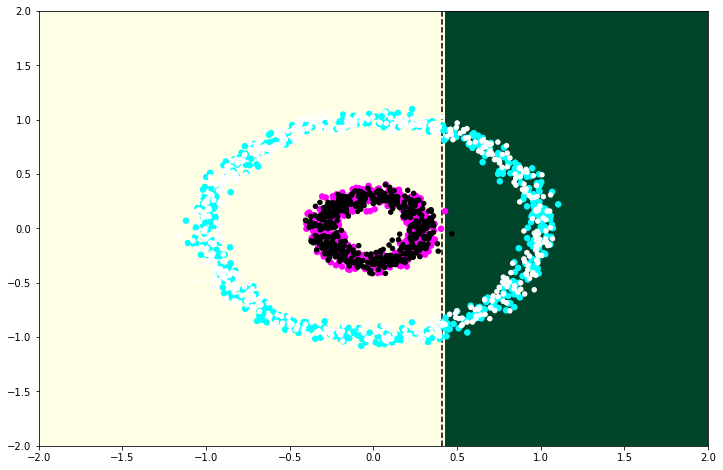

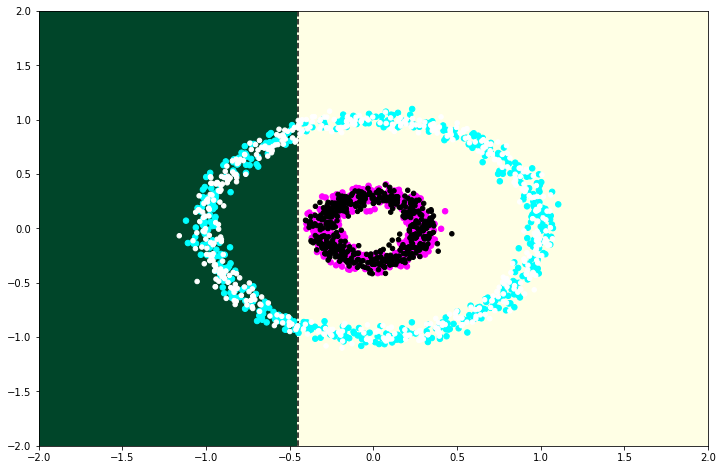

Finalizado.


In [163]:
criterion =['gini','entropy']
splitter = ['best','random']

for c,s in itertools.product(criterion,splitter):
    name = '{}-{}'.format(c,s)
    model = Tree(criterion=c,splitter=s,random_state=0,max_depth=1)
    model.fit(X_train,y_train)
    acc_train = model.score(X_train,y_train)
    acc_test = model.score(X_test,y_test)
    prec_rec = precision_recall_fscore_support(y_test,model.predict(X_test))[:1]
    dict_info[name] = [acc_train,acc_test]+list(prec_rec)
    plot_classifier(model,X_train,y_train,X_test,y_test,"tree")
print('Finalizado.')

In [164]:
df = pd.DataFrame(dict_info)
df

,entropy-best,entropy-random,gini-best,gini-random
0,0.697,0.672,0.705,0.672
1,0.658,0.679,0.67,0.679
2,"[0.994011976048, 0.590636254502]","[1.0, 0.605651105651]","[0.983606557377, 0.599755201958]","[1.0, 0.605651105651]"


#### e) Demuestre experimentalmente que un árbol de clasificación de múltiples niveles puede resolver satis- factoriamente el problema estudiado. Puede utilizar el criterio y la función de partición que prefiera,pero puede optar tranquilamente por usar los hiper-parámetros que se entregan como referencia en el código de ejemplo. Cambie el número de niveles admitidos en el árbol N t entre 2 y 20, graficando el error de entrenamiento y pruebas como función de N t. Describa y explique lo que observa. Utilice la función plot classifier, diseñada anteriormente, para construir gráficos de la solución en algunos casos representativos.


In [165]:
dict_info = {}

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


C:\Python36\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


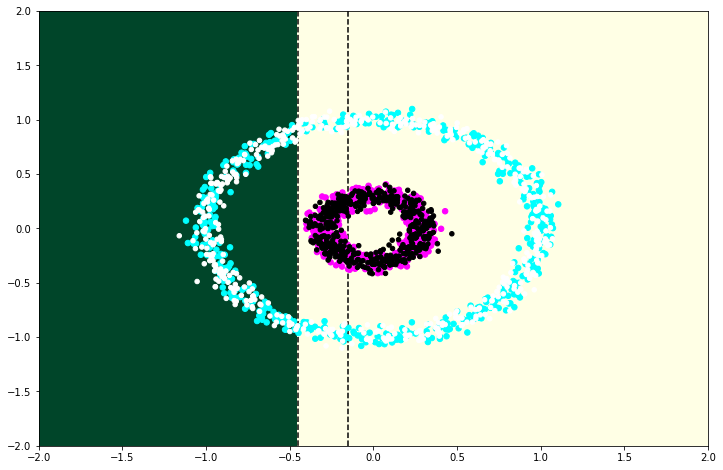

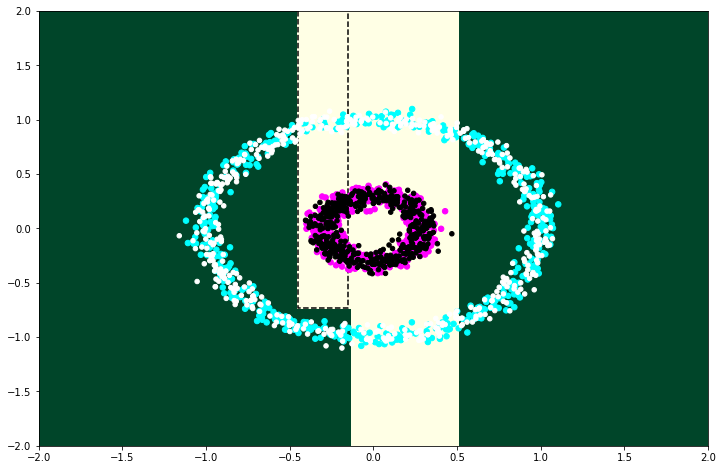

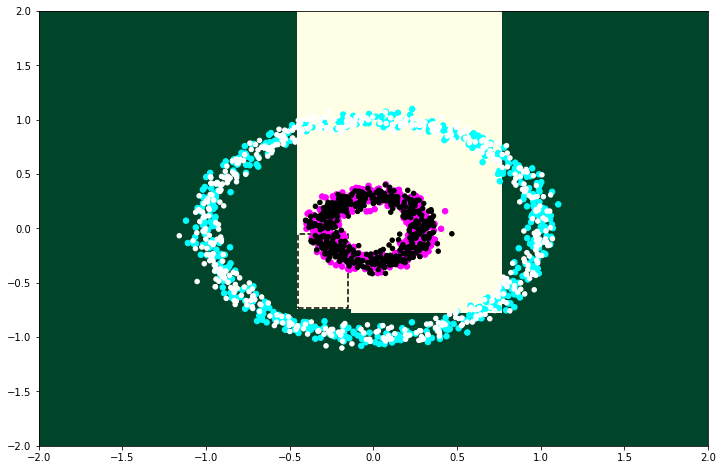

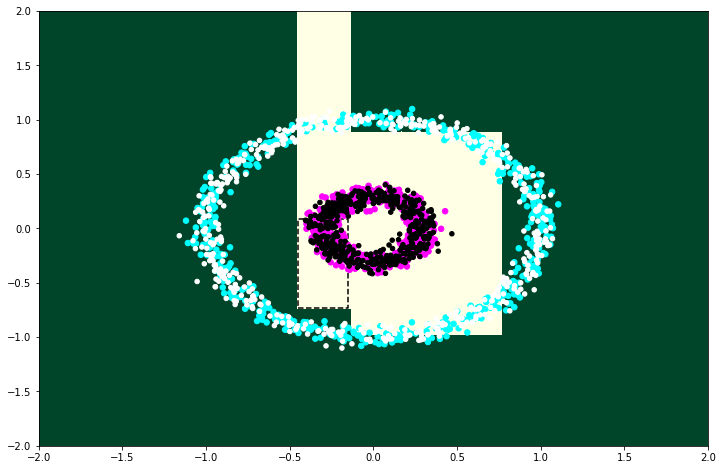

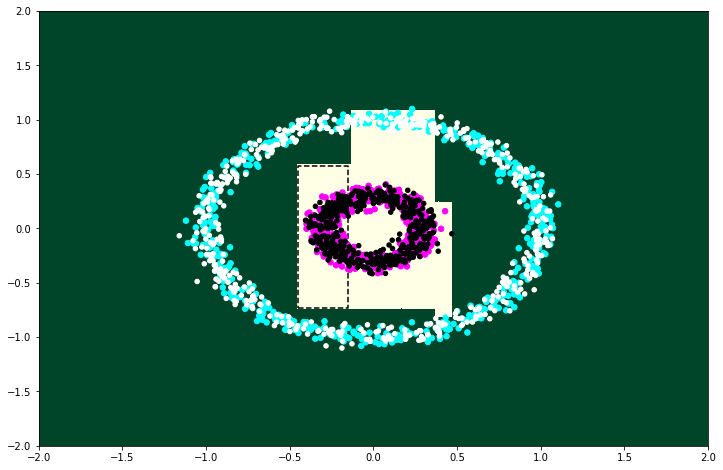

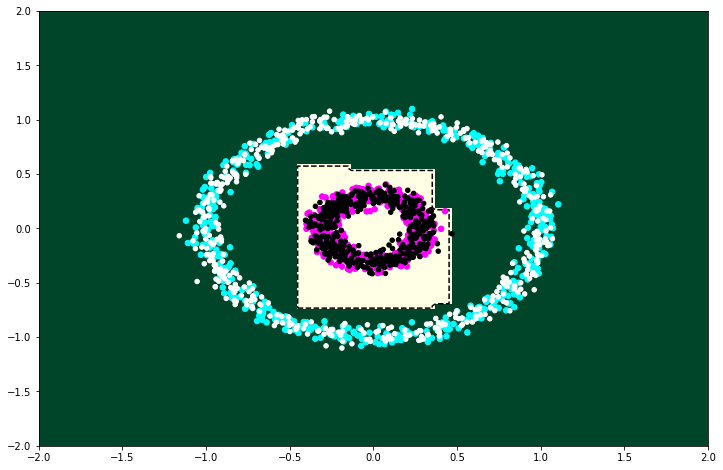

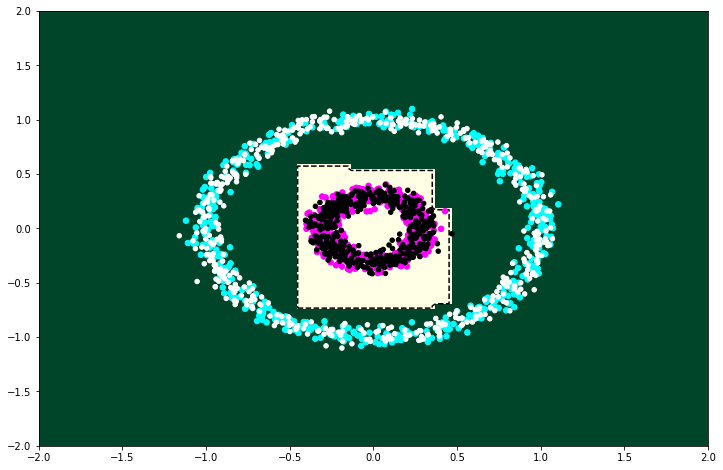

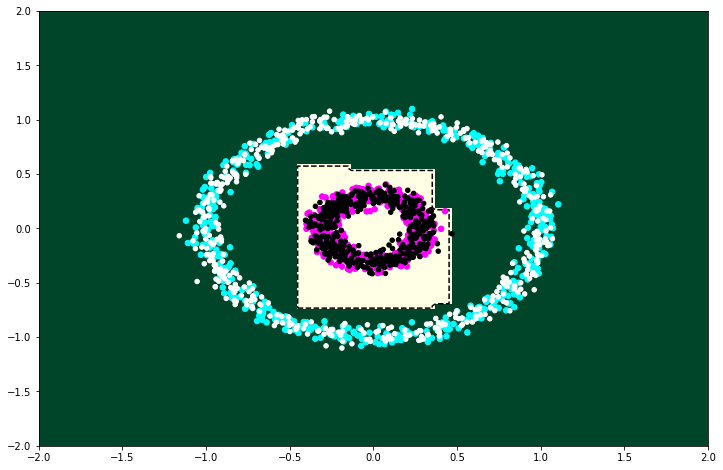

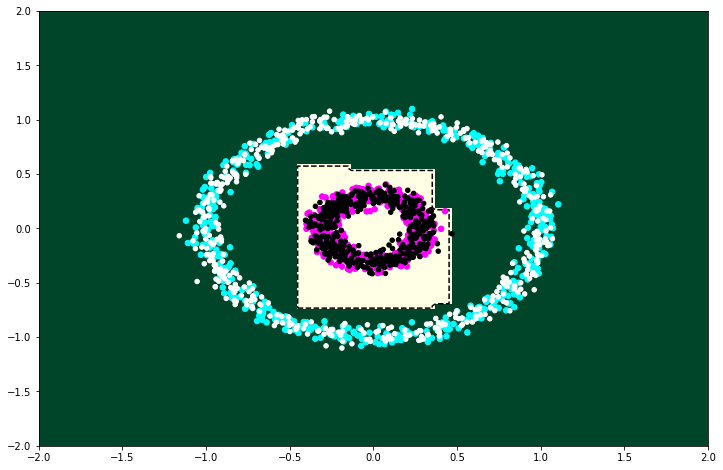

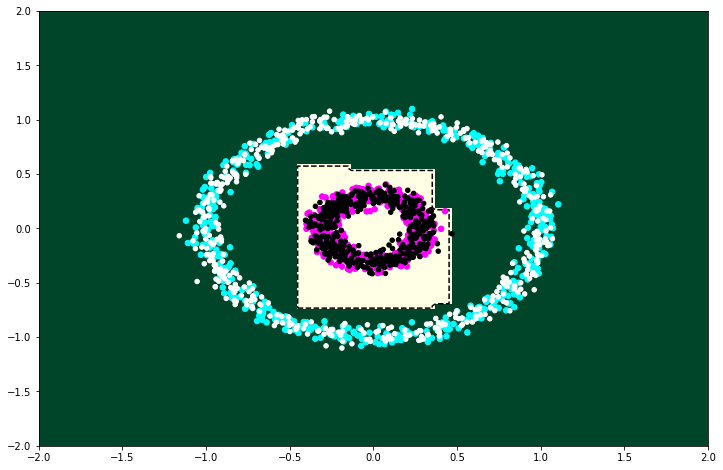

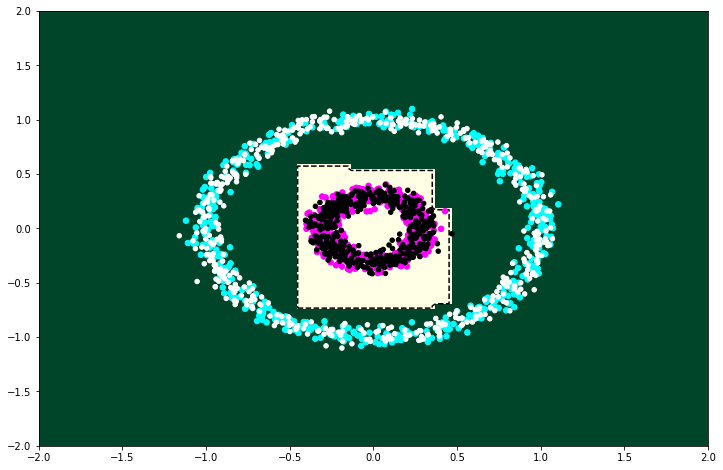

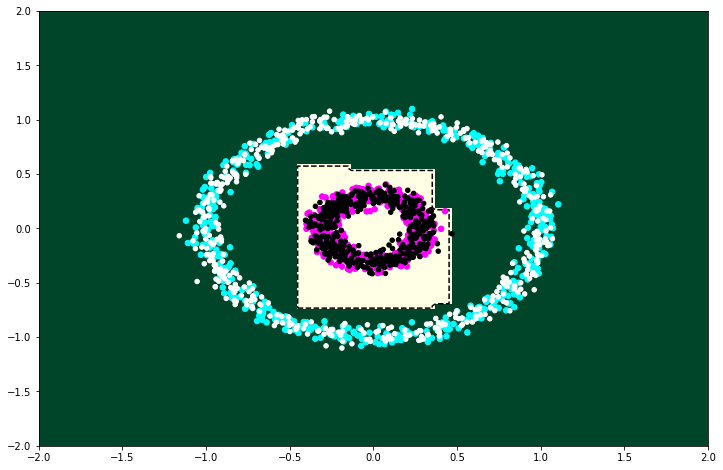

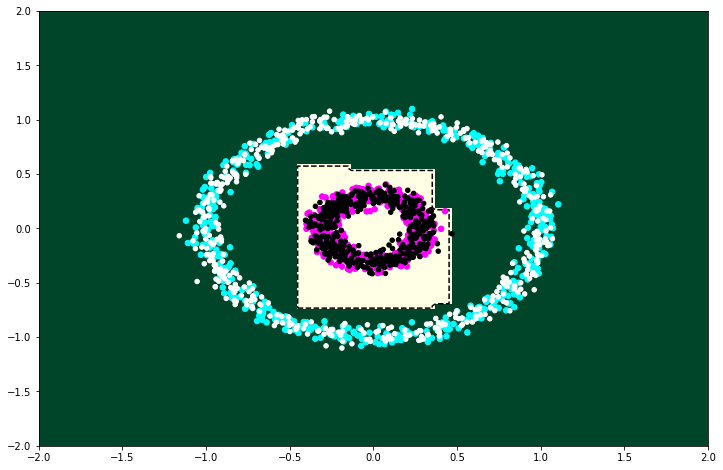

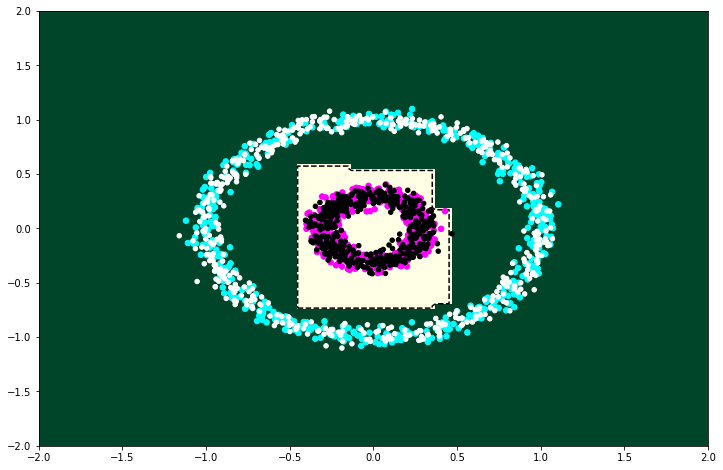

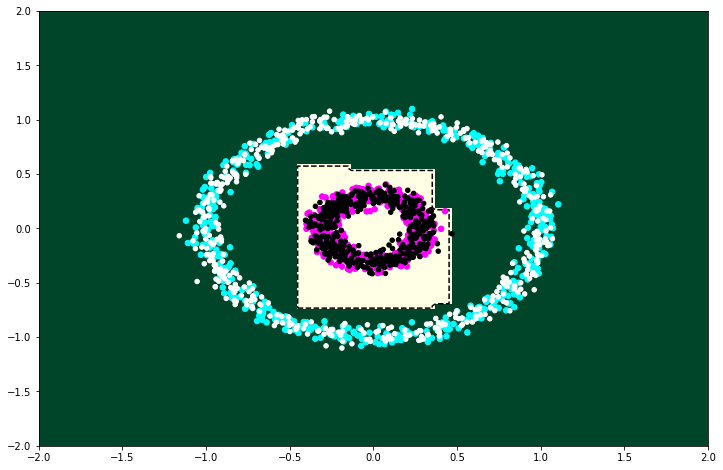

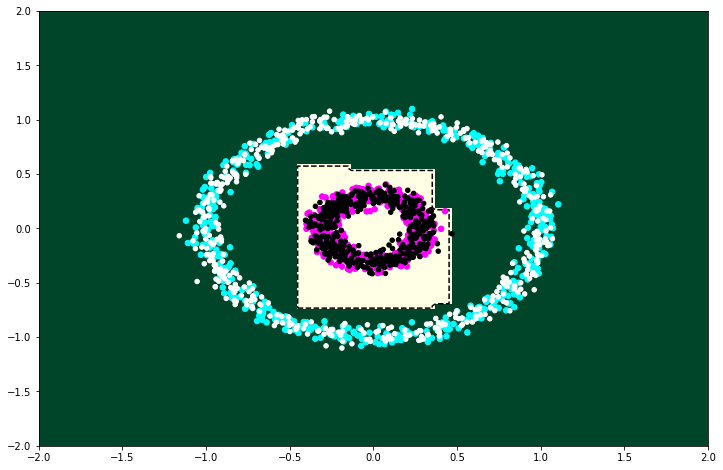

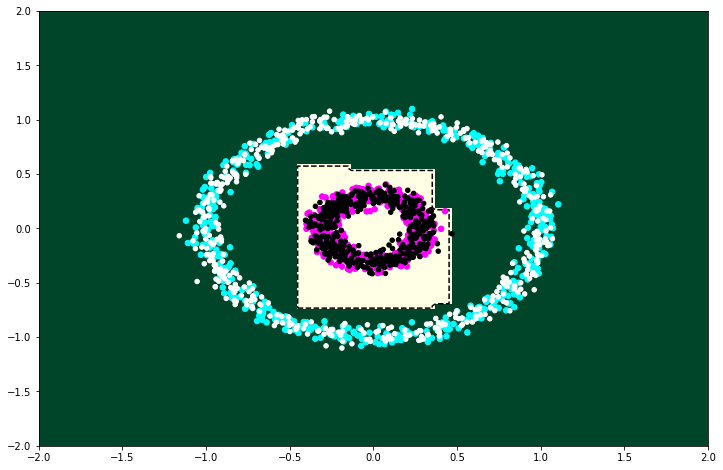

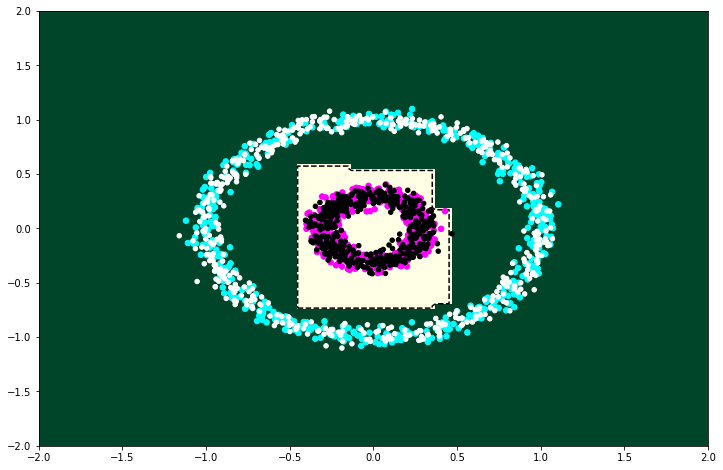

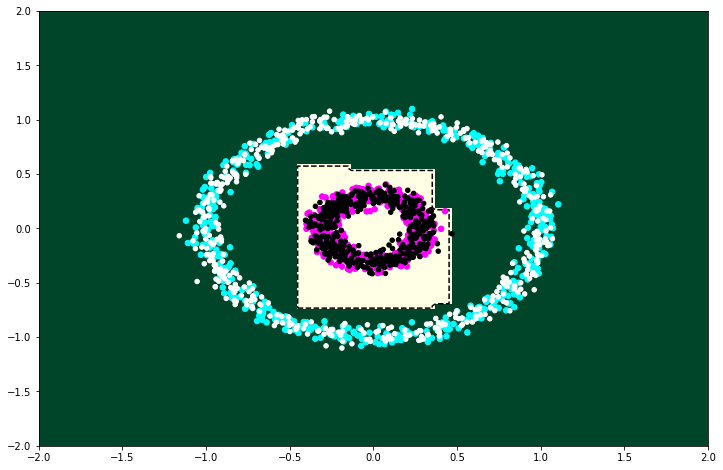

best test accuracy :0.999 , n:7
Finalizado.


In [167]:
N_t = [i for i in range(2,21)]
print(N_t)
best_acc = [0,0]
for n in N_t:
    model = Tree(criterion='entropy',splitter='random',random_state=0,max_depth=n)
    model.fit(X_train,y_train)
    acc_train = model.score(X_train,y_train)
    acc_test = model.score(X_test,y_test)
    prec_rec = precision_recall_fscore_support(y_test,model.predict(X_test))[:1]
    dict_info[str(n)] = [acc_train,acc_test]+list(prec_rec)
    if acc_test > best_acc[0]:
            best_acc = [acc_test,n]
    plot_classifier(model,X_train,y_train,X_test,y_test,"tree")
print ('best test accuracy :{} , n:{}'.format(best_acc[0],best_acc[1]))    
print('Finalizado.')

In [176]:
df = pd.DataFrame().from_dict(dict_info,orient='index')
df

,0,1,2
2,0.672,0.679,"[1.0, 0.605651105651]"
3,0.877,0.857,"[1.0, 0.775157232704]"
4,0.887,0.864,"[1.0, 0.783783783784]"
5,0.888,0.876,"[1.0, 0.799027552674]"
6,0.960,0.955,"[0.997844827586, 0.917910447761]"
7,1.000,0.999,"[0.998031496063, 1.0]"
8,1.000,0.999,"[0.998031496063, 1.0]"
9,1.000,0.999,"[0.998031496063, 1.0]"
10,1.000,0.999,"[0.998031496063, 1.0]"
11,1.000,0.999,"[0.998031496063, 1.0]"


#### f) Como ya se demostró experimentalmente que este problema es linealmente inseperable, ahora se pide experimentar otra alternativa. Para ello deberá realizar una proyección de los datos a un nuevo espacio dimensional (manifold) en el cual se reconozcan sus patrones no lineales, para poder trabajarlos confronteras lineales. Utilice la técnica de PCA con la ayuda de un Kernel  Gaussiano para extraer sus vectores con dimensión infinita de mayor varianza.

In [198]:
kpca = KernelPCA(kernel="rbf", gamma=5,fit_inverse_transform=True)
kpca = kpca.fit(X_train)
Xkpca_train = kpca.transform(X_train)
Xkpca_test = kpca.transform(X_test)

Xback_train = kpca.inverse_transform(Xkpca_train)
Xback_test = kpca.inverse_transform(Xkpca_test)

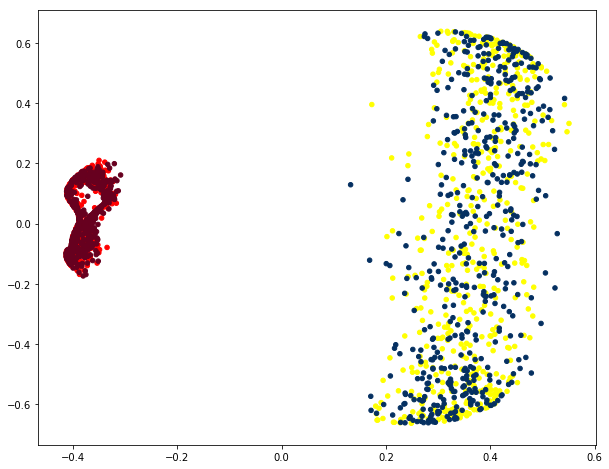

In [199]:
f, axis = plt.subplots(1, 1, sharex='col', sharey='row',figsize=(10,8))
axis.scatter(Xkpca_train[:,0],Xkpca_train[:,1],s=20,c=y_train,zorder=20,cmap='autumn')
axis.scatter(Xkpca_test[:,0],Xkpca_test[:,1],s=20,c=y_test,zorder=20,cmap='RdBu')
plt.axis('tight')
plt.legend(fancybox=True, loc=(1,0.8))
plt.show()

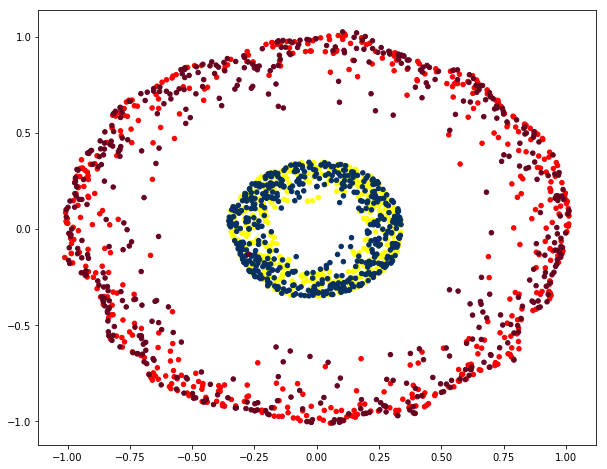

In [200]:
f, axis = plt.subplots(1, 1, sharex='col', sharey='row',figsize=(10,8))
axis.scatter(Xback_train[:,0],Xback_train[:,1],s=20,c=y_train,zorder=20,cmap='autumn')
axis.scatter(Xback_test[:,0],Xback_test[:,1],s=20,c=y_test,zorder=20,cmap='RdBu')
plt.axis('tight')
plt.legend(fancybox=True, loc=(1,0.8))
plt.show()

#### g) Ajuste un algoritmo de aprendizaje con fronteras lineal para los datos proyectados en este nuevo espacio que captura sus  componentes no lineales, muestre gráficamente que el problema ahora puede ser resulto con estos métodos. Reporte métricas para evaluar el desempeño, comente y concluya.

In [249]:
from sklearn.svm import SVC


def visualize_border(model, x_data, y_data, title='', legend=['Categoria1', 'Categoria 2']):
    fig = plt.figure(figsize=(12,6))
    classes = [0,1]
    colors = [plt.cm.cool(float(i)) for i in classes]
    plt.scatter(x_data[y_data==0][:,0], x_data[y_data==0][:,1], s=50, c=colors[0], label=legend[0])
    plt.scatter(x_data[y_data==1][:,0], x_data[y_data==1][:,1], s=50, c=colors[1], label=legend[1])
    plt.grid(True)
    if model != None:
        x_min, x_max = plt.xlim()
        y_min, y_max = plt.ylim()
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z[:,0].reshape(xx.shape)
        plt.contour(xx, yy, Z, 1, cmap=plt.cm.hot)
        plt.axis((x_min, x_max, y_min, y_max))
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
#model = SVC(random_state=44,probability=True,kernel='linear')
#model.fit(X_train, y_train)    
#visualize_border(model,X_test,y_test,'linear svm')

model1 = SVC(random_state=44,probability=True,kernel='linear')
model1.fit(Xkpca_train, y_train)   
print(Xkpca_test.shape)
print(Xback_test.shape)
print(X_test.shape)
print(y_test.shape)
visualize_border(model1,Xback_test,y_test,'fixed linear svm')


(1000, 829)
(1000, 2)
(1000, 2)
(1000,)


ValueError: X.shape[1] = 2 should be equal to 829, the number of features at training time

In [234]:
from matplotlib.colors import ListedColormap

def BoundaryLine(kernel, algo, algo_name):
    reduction = KernelPCA(n_components=2, kernel = kernel)
    x_train_reduced = reduction.fit_transform(X_train)
    x_test_reduced = reduction.transform(X_test)
    
    classifier = algo
    classifier.fit(x_train_reduced, y_train)
    
    y_pred = classifier.predict(x_test_reduced)
    
    print(classification_report(y_test, y_pred))
    
    plt.subplot(2,1,1)
    #Train set boundary
    X_set, y_set = x_train_reduced, y_train
    X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                         np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
    plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
                 alpha = 0.6, cmap = ListedColormap(('red', 'green')))
    plt.xlim(X1.min(), X1.max())
    plt.ylim(X2.min(), X2.max())
    for i, j in enumerate(np.unique(y_set)):
        plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                    c = ListedColormap(('red', 'green'))(i), label = j)
    plt.title('{} Boundary Line with {} PCA (Train Set)' .format(algo_name, kernel))
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    
    
    plt.subplot(2,1,2)
    #Test set boundary
    X_set, y_set = x_test_reduced, y_test
    X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                         np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
    plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
                 alpha = 0.6, cmap = ListedColormap(('red', 'green')))
    plt.xlim(X1.min(), X1.max())
    plt.ylim(X2.min(), X2.max())
    for i, j in enumerate(np.unique(y_set)):
        plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                    c = ListedColormap(('red', 'green'))(i), label = j)
    plt.title('{} Boundary Line with {} PCA (Test Set)' .format(algo_name, kernel))
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.tight_layout()
    plt.show()

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       507
          1       1.00      1.00      1.00       493

avg / total       1.00      1.00      1.00      1000



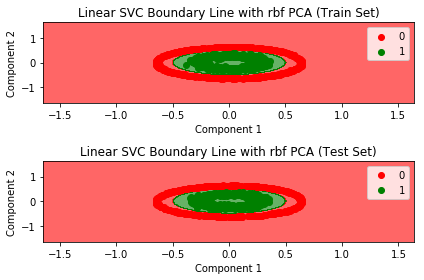

In [237]:
BoundaryLine('rbf', SVC(), "Linear SVC")